In [1]:
import numpy as np

# ---- constantes ----
A1 = 2.6e-3  # [m²]
vp = 2.0  # [m³]
Lc = 2.0  # [m]
Kv = 0.38  # [-]
P1 = 4500  # Pa
P_out = 5000  # [Pa]
C1 = 479.0  # [m/s]


def phi(N, m_dot):
    """Aproximação polinomial de phi(N, m_dot)"""
    a = [
        8.08424885e-01,
        1.46255600e-05,
        1.20236697e-02,
        2.91248126e-10,
        -3.55829871e-06,
        2.88286910e-03,
        -5.67879568e-15,
        6.92841254e-11,
        1.18792676e-07,
        -6.17384309e-04,
    ]

    return (
        a[0]
        + a[1] * N
        + a[2] * m_dot
        + a[3] * N**2
        + a[4] * N * m_dot
        + a[5] * m_dot**2
        + a[6] * N**3
        + a[7] * N**2 * m_dot
        + a[8] * N * m_dot**2
        + a[9] * m_dot**3
    )


def ode_system(t, x, alpha_func, N_func):
    m_dot, Pp = x

    alpha, N = alpha_func(t), N_func(t)
    phi_value = phi(N, m_dot)

    dm_dt = (A1 / Lc) * ((phi_value * P1) - Pp)
    dp_dt = ((C1**2) / vp) * (m_dot - alpha * Kv * np.sqrt(Pp - P_out))

    return [dm_dt, dp_dt]


# Gerando entradas com PRBS


In [2]:
rng = np.random.default_rng(seed=42)

T_switch = 1.0  # tempo de permanência de cada nível
t_end = 120.0  # tempo total da simulação
t_prbs = np.arange(0, t_end, T_switch)

alpha_prbs = rng.choice([0.35, 0.65], size=len(t_prbs))
N_prbs = rng.choice([38500, 42500], size=len(t_prbs))


def alpha_func(t: float) -> float:
    idx = int(np.floor(t / T_switch))
    idx = min(idx, len(alpha_prbs) - 1)
    return alpha_prbs[idx]


def N_func(t: float) -> float:
    idx = int(np.floor(t / T_switch))
    idx = min(idx, len(N_prbs) - 1)
    return N_prbs[idx]


# Simulation


In [3]:
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

x0_guess = [7.0, 6500.0]  # chute inicial
x0 = fsolve(lambda x: ode_system(0, x, alpha_func, N_func), x0_guess)
print("Condições iniciais:", x0)

t = np.arange(0, t_end + 0.1, 0.1)
sol = solve_ivp(
    ode_system,
    t_span=[t[0], t[-1]],
    y0=x0,
    args=(alpha_func, N_func),
    t_eval=t,
    method="BDF",
)


Condições iniciais: [5.41239789e+00 6.65606032e+03]


/tmp/ipykernel_352994/4094341200.py:49: RuntimeWarning: invalid value encountered in sqrt
  dp_dt = ((C1**2) / vp) * (m_dot - alpha * Kv * np.sqrt(Pp - P_out))


In [4]:
m_dot = sol.y[0]
Pp = sol.y[1]
N = np.array([N_func(t) for t in sol.t])
alpha = np.array([alpha_func(t) for t in sol.t])

add_noise = True
if add_noise:
    noise_m_dot = rng.normal(0, 0.05, size=m_dot.shape)
    noise_Pp = rng.normal(0, 20, size=Pp.shape)

    m_dot += noise_m_dot
    Pp += noise_Pp


## Plotando Simulação


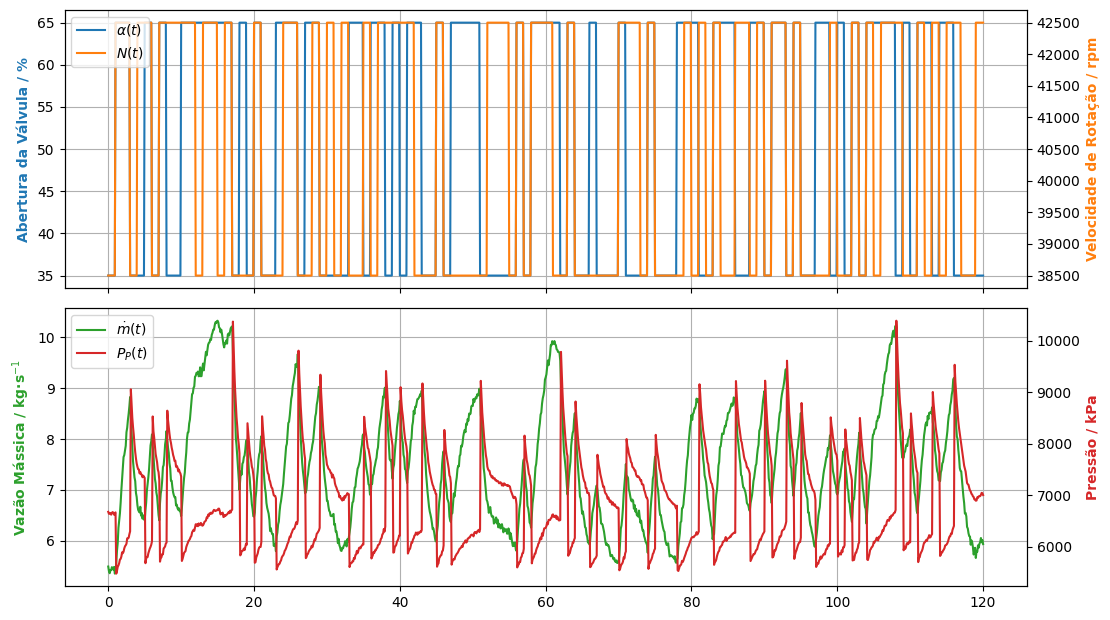

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

colors = list(mcolors.TABLEAU_COLORS.keys())

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(16 * 0.7, 9 * 0.7))

ax_alpha = axs[0]
ax_N = ax_alpha.twinx()
ax_m = axs[1]
ax_P = ax_m.twinx()
axs = [ax_alpha, ax_N, ax_m, ax_P]

(alpha_line,) = axs[0].plot(t, alpha * 100, color=colors[0], label="$\\alpha(t)$")
axs[0].set_ylabel("Abertura da Válvula / %", color=colors[0], weight="bold")
axs[0].grid(True)

(N_line,) = axs[1].plot(t, N, color=colors[1], label="$N(t)$")
axs[1].set_ylabel("Velocidade de Rotação / rpm", color=colors[1], weight="bold")
axs[1].legend(handles=[alpha_line, N_line], loc="upper left")

(m_line,) = axs[2].plot(t, m_dot, label="$\\dot{m}(t)$", color=colors[2])
axs[2].set_ylabel("Vazão Mássica / kg·s$^{-1}$", color=colors[2], weight="bold")
axs[2].grid(True)

(Pp_line,) = axs[3].plot(t, Pp, color=colors[3], label="$P_P(t)$")
axs[3].set_ylabel("Pressão / kPa", color=colors[3], weight="bold")
axs[3].legend(handles=[m_line, Pp_line], loc="upper left")

axs[-1].set_xlabel("Tempo / s")

plt.tight_layout()
plt.show()


# Salvando CSV


In [6]:
import pandas as pd

data = {
    "t": sol.t,
    "m_dot": m_dot,
    "Pp": Pp,
    "N": N,
    "alpha": alpha,
}

df = pd.DataFrame(data)
df.to_csv("../data/simulation.csv", index=False)

# Salvar em váriavel desvio
m_dot -= x0[0]
Pp -= x0[1]
N -= N_func(0)
alpha -= alpha_func(0)

data = {
    "t": sol.t,
    "m_dot": m_dot,
    "Pp": Pp,
    "N": N,
    "alpha": alpha,
}

df = pd.DataFrame(data)
df.to_csv("../data/simulation_deviation.csv", index=False)
